# Computer Vision - CNNs for Image Classification

# 3.1 DATA PREPARATION

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import clone_model, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [56]:
cifar10 = tf.keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [57]:
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Traning set labels: {y_train.shape}")
print(f"Test set labels: {y_test.shape}")

Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)
Traning set labels: (50000, 1)
Test set labels: (10000, 1)


In [58]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

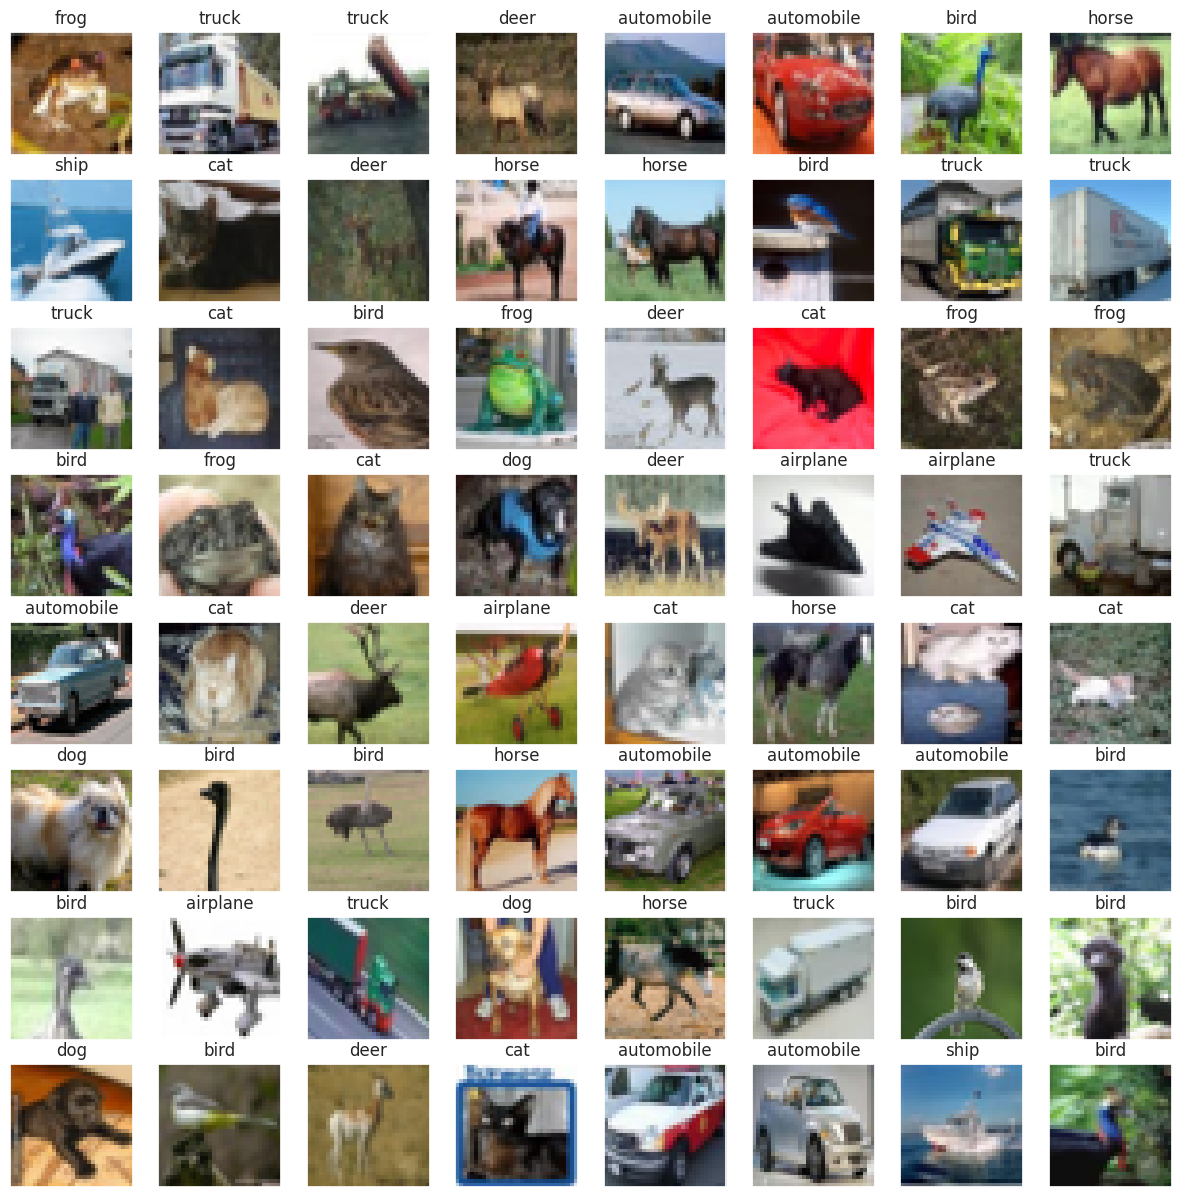

In [59]:
plt.figure(figsize=(15,15))

for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(X_train[i])

    plt.title(class_names[y_train[i][0]], fontsize=12)

plt.show()

In [60]:
# what is an image?
X_train[0][0][0]

array([59, 62, 63], dtype=uint8)

In [61]:
np.max(X_train), np.min(X_train)

(np.uint8(255), np.uint8(0))

In [62]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [63]:
unique, counts = np.unique(y_train, return_counts=True)

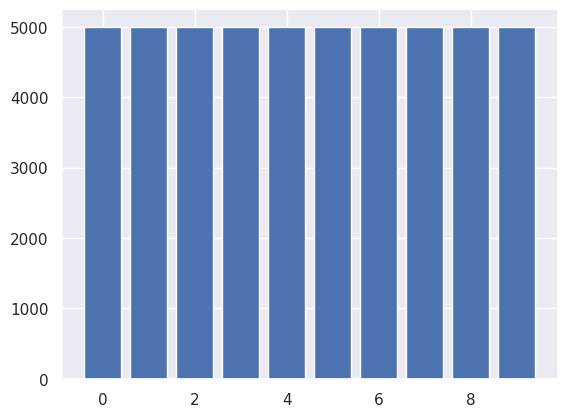

In [64]:
plt.bar(unique, counts)
plt.show()

# 3.2 BASELINE MODEL

In [65]:
cnn_model = models.Sequential(name="CNN_model")

cnn_model.add(layers.InputLayer(input_shape=(32, 32, 3)))

#conv 1
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.25))

#conv 2
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.25))

# Flatten
cnn_model.add(layers.Flatten())

#  Dense
cnn_model.add(layers.Dense(128, activation='relu'))
cnn_model.add(layers.Dropout(0.5))

# Output
cnn_model.add(layers.Dense(10, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn_model.summary()

Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 582,026 (2.22 MB)

 Trainable params: 582,026 (2.22 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
cnn_history = cnn_model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=256,
                    validation_split=0.1)

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.2294 - loss: 2.0666 - val_accuracy: 0.4736 - val_loss: 1.5096
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.4261 - loss: 1.5759 - val_accuracy: 0.5372 - val_loss: 1.2848
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5068 - loss: 1.3712 - val_accuracy: 0.6154 - val_loss: 1.1042
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5592 - loss: 1.2323 - val_accuracy: 0.6480 - val_loss: 1.0237
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5917 - loss: 1.1524 - val_accuracy: 0.6612 - val_loss: 0.9946
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6142 - loss: 1.0922 - val_accuracy: 0.6940 - val_loss: 0.9004
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6347 - loss: 1.0395 - val_accuracy: 0.7130 - val_loss: 0.8493
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6531 - loss: 0.9938 - val_acc

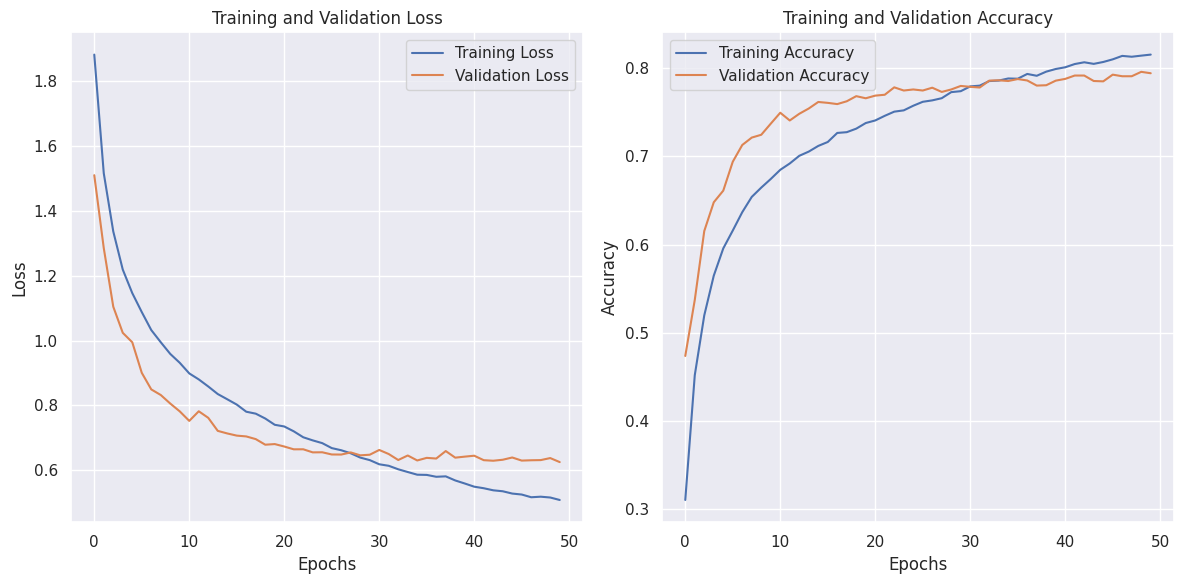

In [67]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [68]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7789 - loss: 0.6536
Test Loss: 0.654900312423706
Test Accuracy: 0.7814000248908997


In [69]:
# Get predictions for the test set
predictions_cnn = cnn_model.predict(X_test)
predicted_labels_cnn = np.argmax(predictions_cnn, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


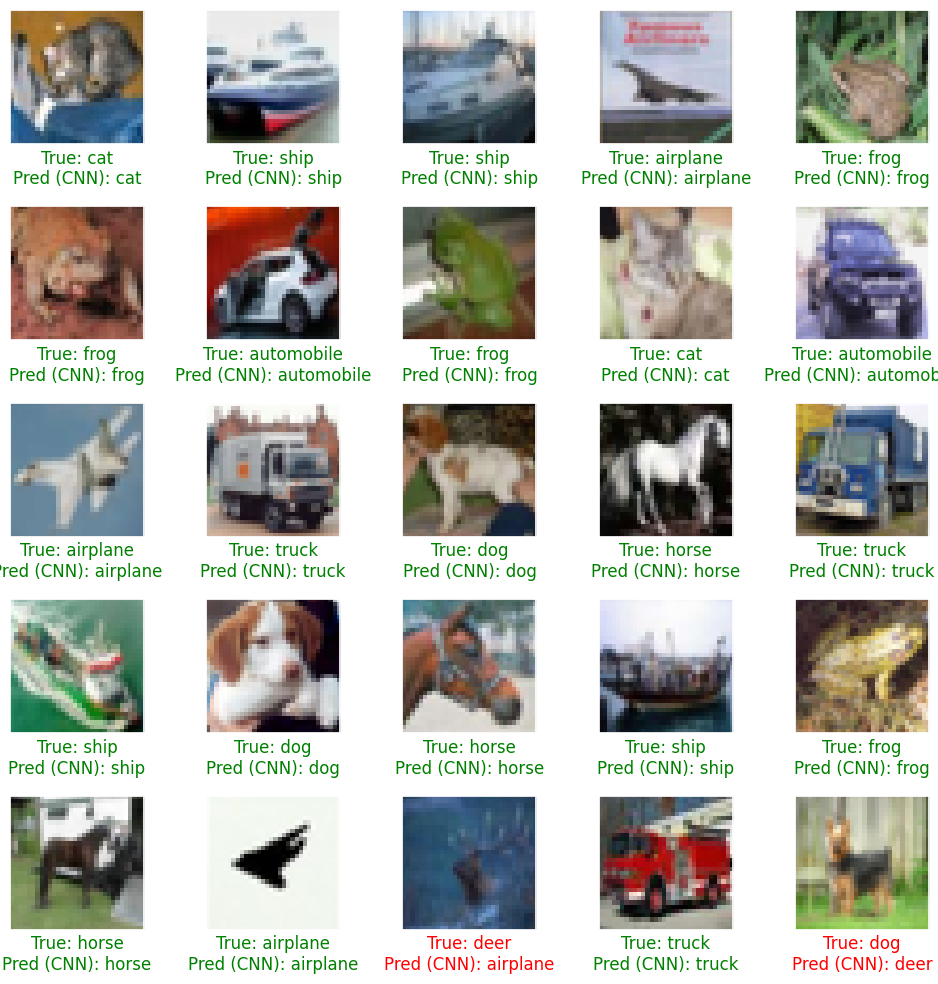

In [70]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i])
    true_label = class_names[y_test[i][0]]
    predicted_label = class_names[predicted_labels_cnn[i]]
    if true_label == predicted_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f"True: {true_label}\nPred (CNN): {predicted_label}", color=color)
plt.tight_layout()
plt.show()

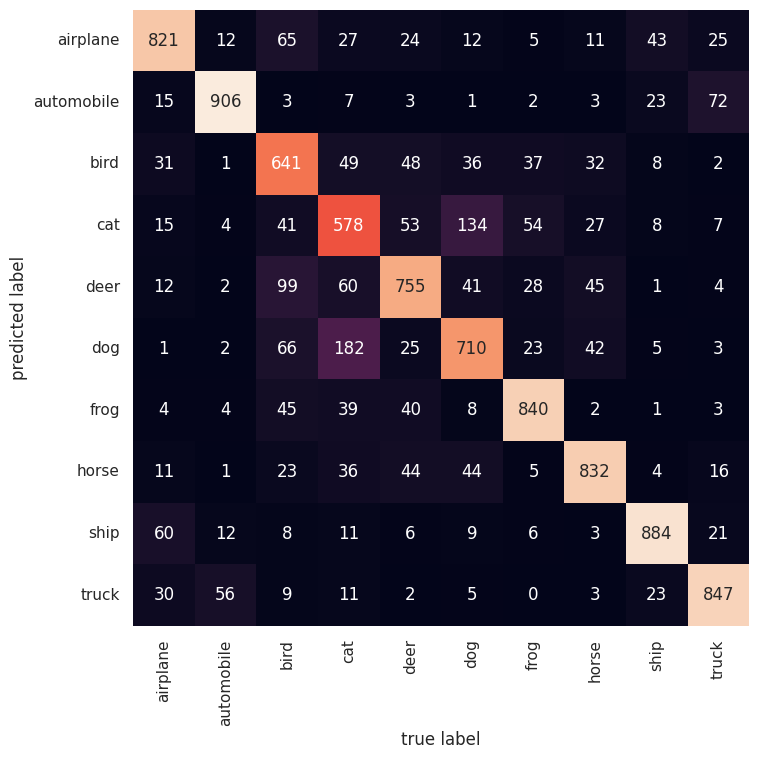

In [71]:
mat = confusion_matrix(y_test, predicted_labels_cnn)
plt.figure(figsize=(8, 8)); sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label'); plt.ylabel('predicted label'); plt.show()

In [72]:
print(classification_report(y_test, predicted_labels_cnn, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.79      0.82      0.80      1000
  automobile       0.88      0.91      0.89      1000
        bird       0.72      0.64      0.68      1000
         cat       0.63      0.58      0.60      1000
        deer       0.72      0.76      0.74      1000
         dog       0.67      0.71      0.69      1000
        frog       0.85      0.84      0.85      1000
       horse       0.82      0.83      0.83      1000
        ship       0.87      0.88      0.88      1000
       truck       0.86      0.85      0.85      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



# 3.3 IMPROVED MODEL

In [73]:
from tensorflow.keras import models, layers, optimizers, callbacks

# Build improved CNN
cnn_model_Improved = models.Sequential(name="Enhanced_CNN")

# Input
cnn_model_Improved.add(layers.InputLayer(input_shape=(32, 32, 3)))

# Conv Block 1
cnn_model_Improved.add(layers.Conv2D(32, (3,3), padding='same'))
cnn_model_Improved.add(layers.BatchNormalization())
cnn_model_Improved.add(layers.Activation('relu'))

cnn_model_Improved.add(layers.Conv2D(32, (3,3), padding='same'))
cnn_model_Improved.add(layers.BatchNormalization())
cnn_model_Improved.add(layers.Activation('relu'))

cnn_model_Improved.add(layers.MaxPooling2D((2,2)))
cnn_model_Improved.add(layers.Dropout(0.25))

# Conv Block 2
cnn_model_Improved.add(layers.Conv2D(64, (3,3), padding='same'))
cnn_model_Improved.add(layers.BatchNormalization())
cnn_model_Improved.add(layers.Activation('relu'))

cnn_model_Improved.add(layers.Conv2D(64, (3,3), padding='same'))
cnn_model_Improved.add(layers.BatchNormalization())
cnn_model_Improved.add(layers.Activation('relu'))

cnn_model_Improved.add(layers.MaxPooling2D((2,2)))
cnn_model_Improved.add(layers.Dropout(0.3))

# Conv Block 3 (Extra Depth)
cnn_model_Improved.add(layers.Conv2D(128, (3,3), padding='same'))
cnn_model_Improved.add(layers.BatchNormalization())
cnn_model_Improved.add(layers.Activation('relu'))

cnn_model_Improved.add(layers.MaxPooling2D((2,2)))
cnn_model_Improved.add(layers.Dropout(0.4))

# Flatten
cnn_model_Improved.add(layers.Flatten())

#  Dense
cnn_model_Improved.add(layers.Dense(256))
cnn_model_Improved.add(layers.BatchNormalization())
cnn_model_Improved.add(layers.Activation('relu'))
cnn_model_Improved.add(layers.Dropout(0.5))

# Output
cnn_model_Improved.add(layers.Dense(10, activation='softmax'))

# Optimizer: Adam
optimizer = optimizers.Adam(learning_rate=0.001)

# Compile
cnn_model_Improved.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model_Improved.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "Enhanced_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 668,842 (2.55 MB)

 Trainable params: 667,690 (2.55 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [74]:
# Learning rate scheduler
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

# Early stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint
checkpoint = callbacks.ModelCheckpoint('best_tuned_model.keras',
                                                monitor='val_loss',
                                                save_best_only=True,
                                                verbose=1)


In [75]:
history_fineTuned = cnn_model_Improved.fit(
    X_train, y_train,
    batch_size=256,
    epochs=100,
    validation_split=0.1,
    callbacks=[reduce_lr, early_stop, checkpoint]
)



Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2991 - loss: 2.0932
Epoch 1: val_loss improved from inf to 3.25990, saving model to best_tuned_model.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.2995 - loss: 2.0914 - val_accuracy: 0.1002 - val_loss: 3.2599 - learning_rate: 0.0010
Epoch 2/100
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5040 - loss: 1.3575
Epoch 2: val_loss improved from 3.25990 to 2.93794, saving model to best_tuned_model.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5043 - loss: 1.3568 - val_accuracy: 0.1882 - val_loss: 2.9379 - learning_rate: 0.0010
Epoch 3/100
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5977 - loss: 1.1201
Epoch 3: val_loss improved from 2.93794 to 1.19302, saving model to best_tuned_model.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5979 - loss: 1.1198 - val_accuracy: 0.5842 - val_loss: 1.1930 - learning_rate: 0.0010
Epoch 4/100
175/176 ━━━━━━━━━━━━━━━━━━━

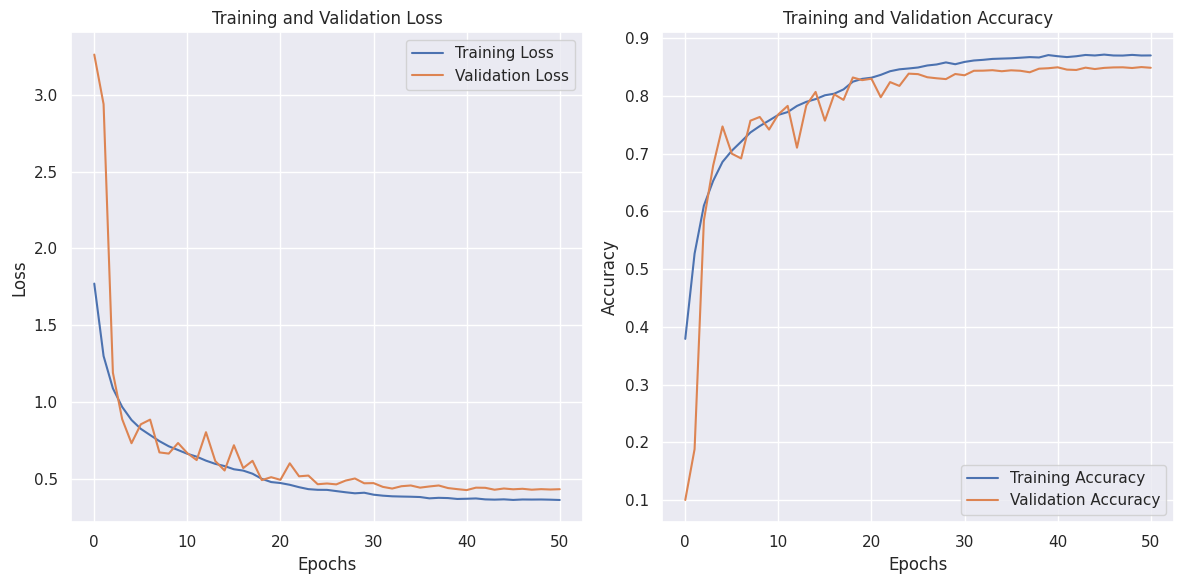

In [76]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_fineTuned.history['loss'], label='Training Loss')
plt.plot(history_fineTuned.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fineTuned.history['accuracy'], label='Training Accuracy')
plt.plot(history_fineTuned.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [77]:
test_loss_fineTuned, test_accuracy_fineTuned = cnn_model_Improved.evaluate(X_test, y_test)
print("Test Loss:", test_loss_fineTuned)
print("Test Accuracy:", test_accuracy_fineTuned)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8476 - loss: 0.4454
Test Loss: 0.44790834188461304
Test Accuracy: 0.8476999998092651


In [78]:
# Get predictions for the test set
predictions_cnn = cnn_model_Improved.predict(X_test)
predicted_labels_cnn = np.argmax(predictions_cnn, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


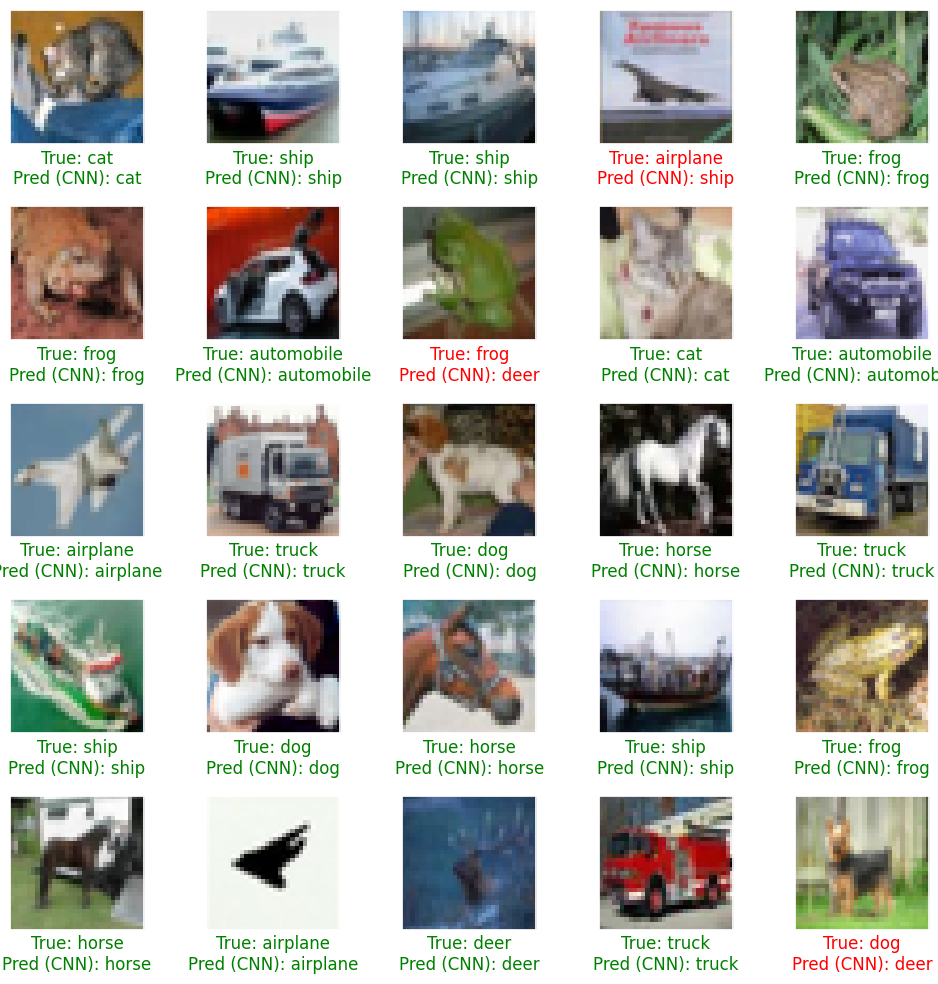

In [79]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i])
    true_label = class_names[y_test[i][0]]
    predicted_label = class_names[predicted_labels_cnn[i]]
    if true_label == predicted_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f"True: {true_label}\nPred (CNN): {predicted_label}", color=color)
plt.tight_layout()
plt.show()

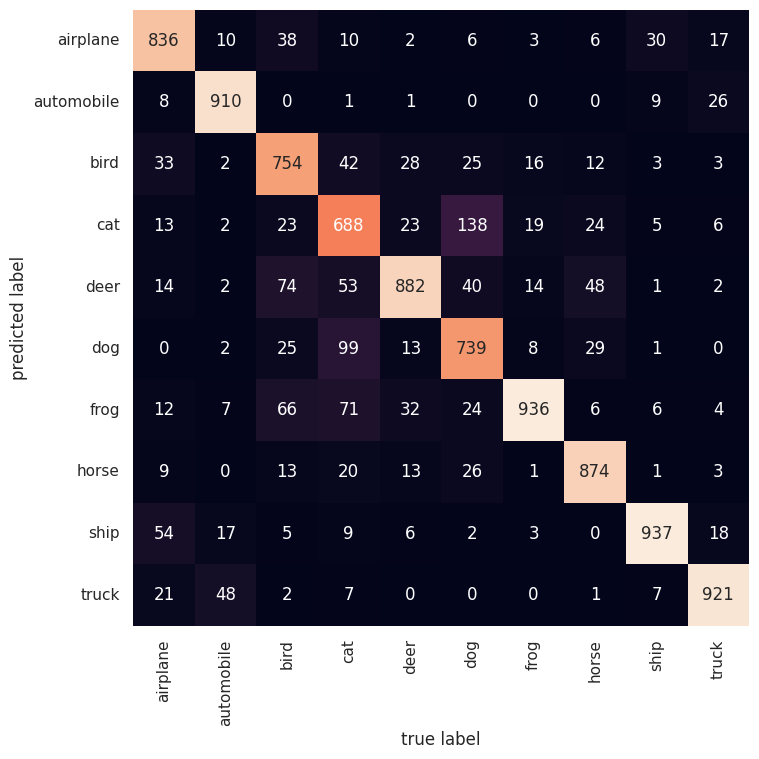

In [80]:
mat = confusion_matrix(y_test, predicted_labels_cnn)
plt.figure(figsize=(8, 8)); sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label'); plt.ylabel('predicted label'); plt.show()

In [81]:
print(classification_report(y_test, predicted_labels_cnn, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.87      0.84      0.85      1000
  automobile       0.95      0.91      0.93      1000
        bird       0.82      0.75      0.79      1000
         cat       0.73      0.69      0.71      1000
        deer       0.78      0.88      0.83      1000
         dog       0.81      0.74      0.77      1000
        frog       0.80      0.94      0.87      1000
       horse       0.91      0.87      0.89      1000
        ship       0.89      0.94      0.91      1000
       truck       0.91      0.92      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



# 3.4 EVALUATION

## • Plot training and validation accuracy/loss.

Baseline Mode :

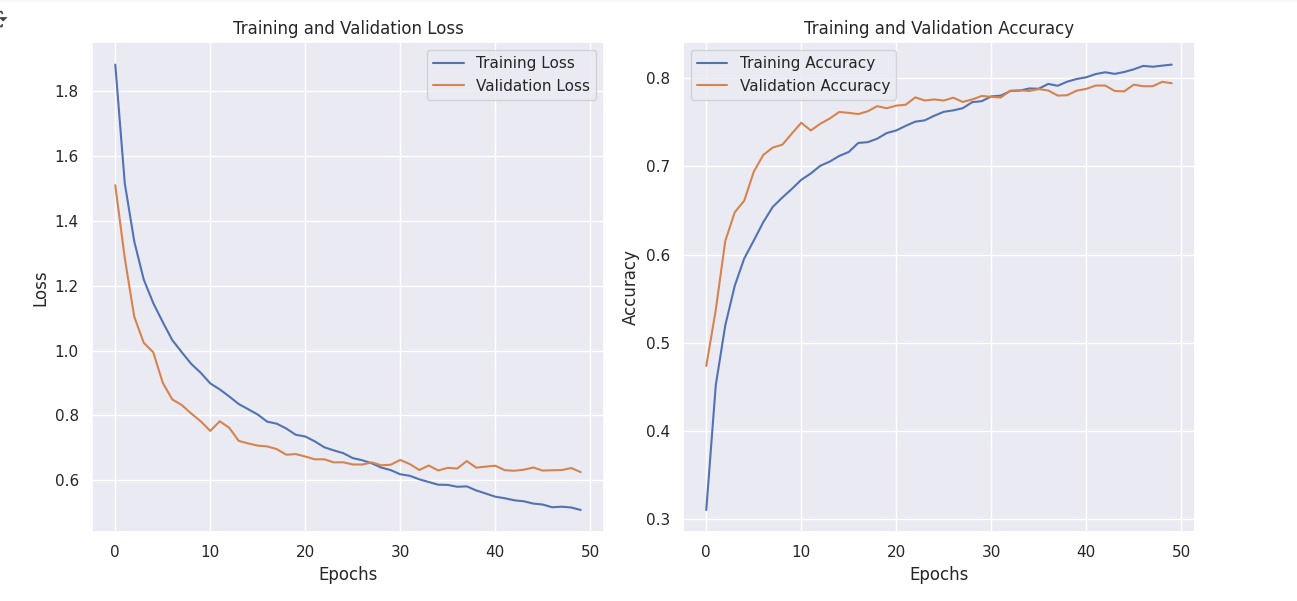

Improved Model:

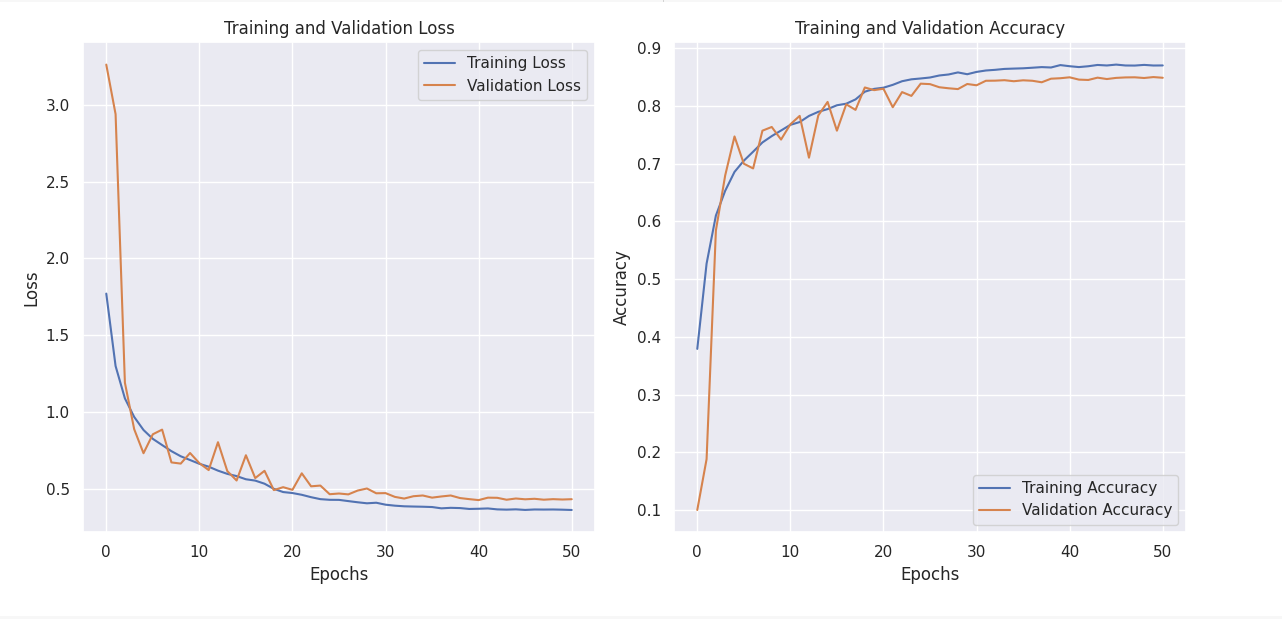

## • Report confusion matrix and classification report.

Baseline Mode :

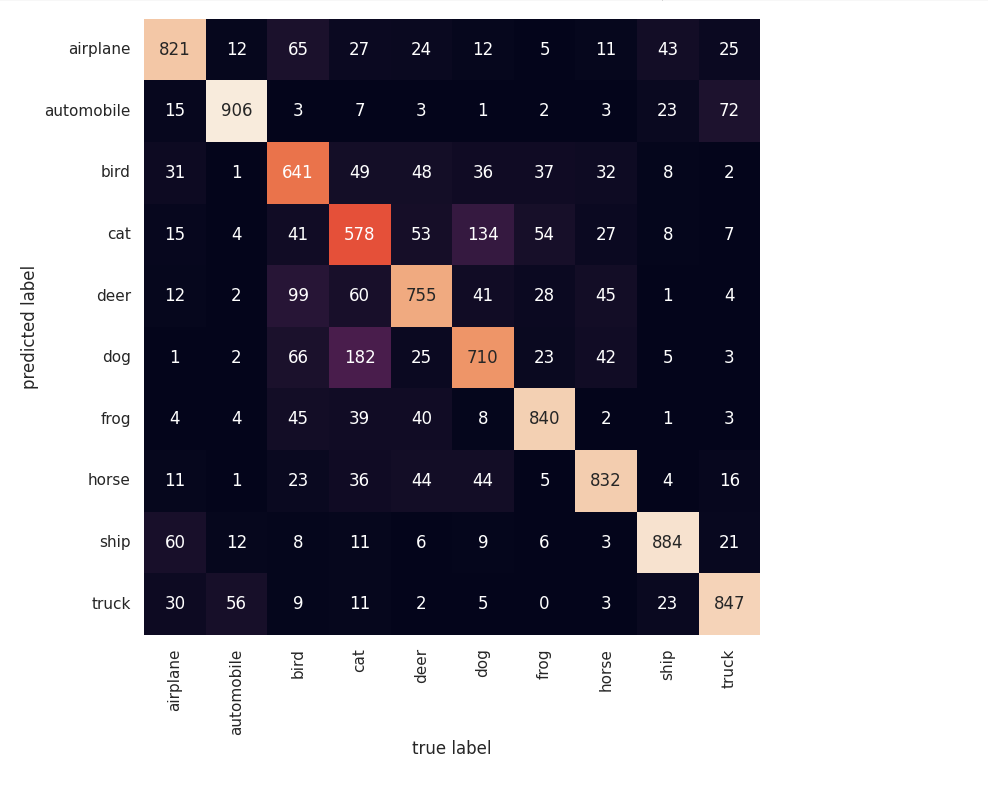

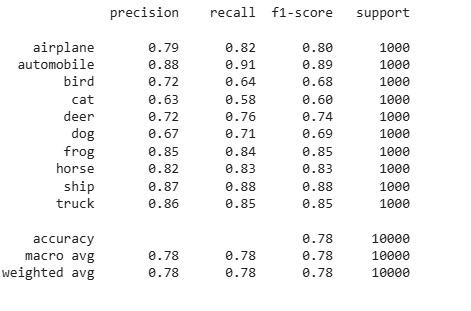

Improved Model:

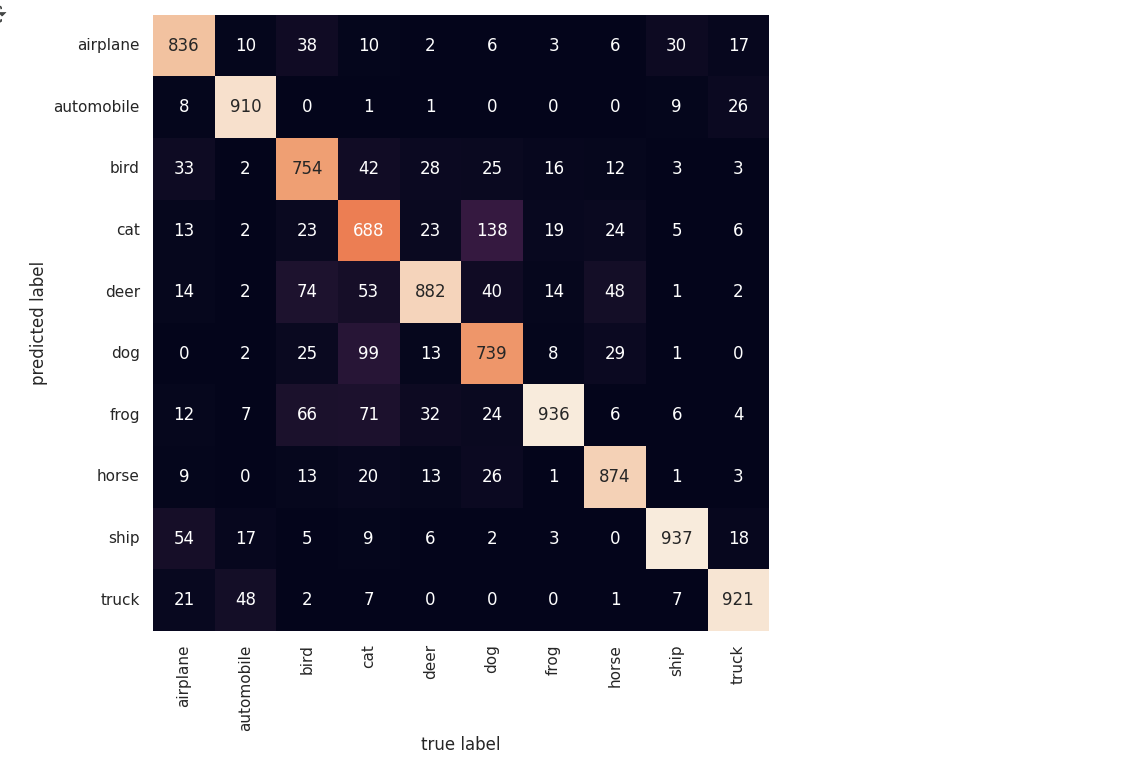

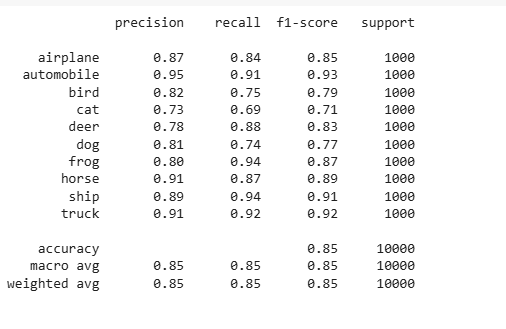

## • Visualize training curves (accuracy and loss).

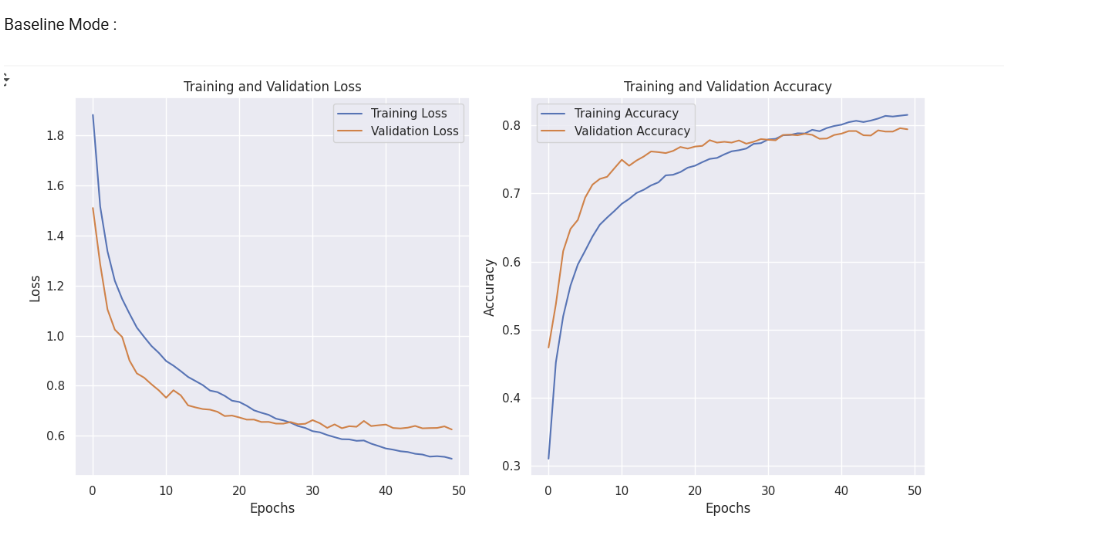

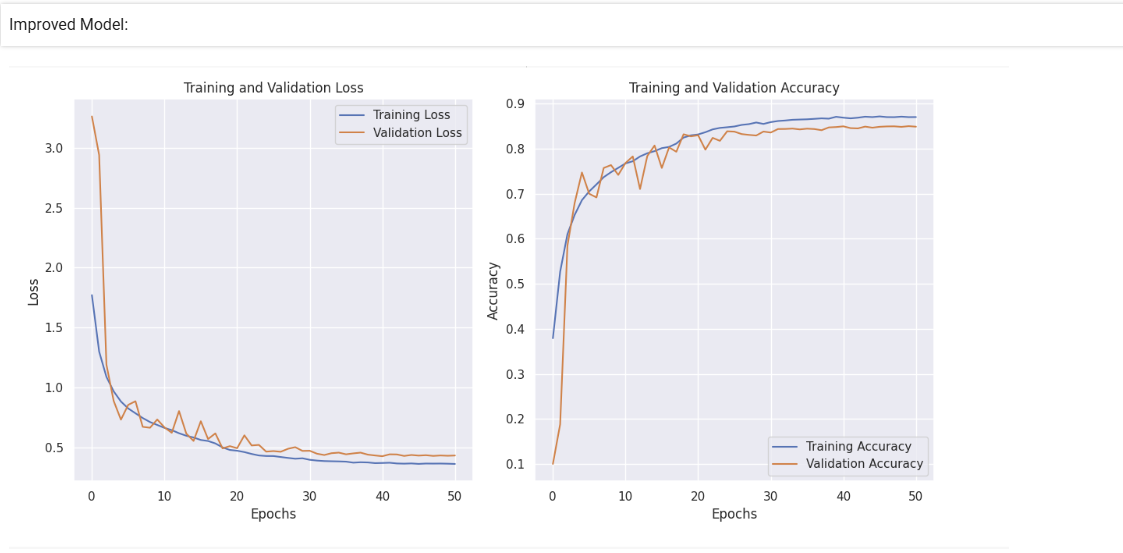

# 4.• Comments on what architectural/ training changes led to improvements and why.

* The model was made deeper with more filters, helping it learn better features.

* Batch Normalization layers improved training stability and accuracy.

* Dropout reduced overfitting.

* The Adam optimizer made learning faster and smoother.

* A learning rate scheduler helped fine-tune the training process.

* Early stopping prevented the model from over-training.

* These changes improved accuracy from 78% to 85% and increased performance on all classes.